# Probabilistic Methods: Assignment Notebook

This notebook contains:
 1. Problem 1: Probability
 2. Problem 2: Statistic
 3. Problem 3: Bayesian Networks for Pima Indians Diabetes

## Problem 1: Probability



In [1]:
import numpy as np

# Analytical expectation
e_v = 0.4 * (2/5) + 0.6 * (2/10)
print(f"Analytical E[T] = {e_v:.3f} hours (~{e_v*60:.1f} minutes)")

Analytical E[T] = 0.280 hours (~16.8 minutes)


In [2]:
# A quick Monte Carlo simulation
np.random.seed(0)
n = 100000
V = np.where(np.random.rand(n) < 0.4, 5, 10) # speed
T = 2.0 / V
print("Simulated E[T] =", T.mean(), "hours")

Simulated E[T] = 0.27996600000000005 hours


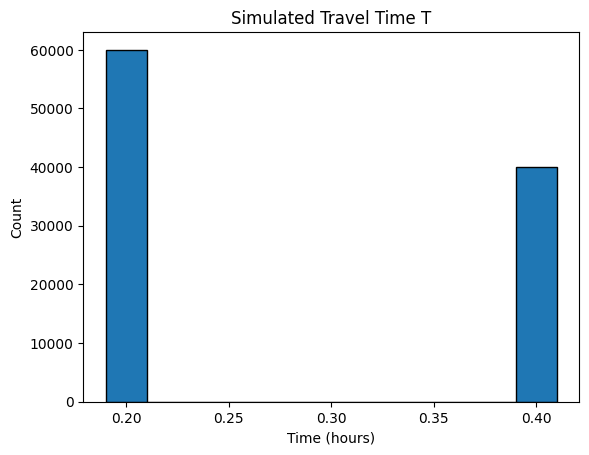

In [3]:
import matplotlib.pyplot as plt

# Histogram
plt.hist(T, bins=[0.19,0.21,0.39,0.41], edgecolor='k')
plt.title('Simulated Travel Time T')
plt.xlabel('Time (hours)')
plt.ylabel('Count')
plt.show()

## Problem 2: Statistic

In [4]:
# Given data
k = 5
n = 15
alpha = 0.05

xbar = 11.07
s2 = 59.71
s = np.sqrt(s2)

### (a) Confidence Interval for Proportion p

In [5]:
from scipy.stats import beta

# lower bound: Beta(alpha/2; k, n-k+1)
ci_low = beta.ppf(alpha/2, k, n - k + 1)
# upper bound: Beta(1-alpha/2; k+1, n-k)
ci_up  = beta.ppf(1 - alpha/2, k + 1, n - k)

print(f"Clopper–Pearson 95% CI: [{ci_low:.3f}, {ci_up:.3f}]")

Clopper–Pearson 95% CI: [0.118, 0.616]


### (b) 97% Confidence Interval for the Mean and Sample Size Calculation

In [6]:
import scipy.stats as st

alpha = 0.03
df = n-1
tval = st.t.ppf(1-alpha/2, df)
half_width = tval * s / np.sqrt(n)
ci_mean = (xbar - half_width, xbar + half_width)
print(f"97% CI for mean: [{ci_mean[0]:.2f}, {ci_mean[1]:.2f}]")

# Required n for width <= 2
target_hw = 1
# approximate solve via iteration
for N in range(15,1000):
    tw = st.t.ppf(1-alpha/2, N-1) * s / np.sqrt(N)
    if tw <= target_hw:
        print(f"Needed sample size for width<=2: n={N}")
        break


97% CI for mean: [6.25, 15.89]
Needed sample size for width<=2: n=285


### (c) Sign Test for the Median

In [7]:
pval_sign = 1 - st.binom.cdf(k-1, n, 0.5)
print(f"Sign test p-value: {pval_sign:.3f}")

Sign test p-value: 0.941


### (d) Test of Independence between Gender and Wait Time Category

In [8]:
from scipy.stats import fisher_exact

# Table: [[men<=16, men>16],[women<=16,women>16]]
table = np.array([[4,3],[6,2]])
oddsratio, p_fisher = fisher_exact(table)
print(f"Fisher exact p-value: {p_fisher:.3f}")

Fisher exact p-value: 0.608


## Problem 3: Bayesian Networks for Pima Indians Diabetes

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools

# Load and show the data
dataset = "pima-indians-diabetes.data.csv"
cols = ["Pregnancies","Glucose","BloodPressure","BMI","Age","Outcome"]
df = pd.read_csv(dataset, header=0, names=cols)
df.head()

,,,Pregnancies,Glucose,BloodPressure,BMI,Age,Outcome
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1


In [10]:
# 1. Preprocessing & Binning
# Variables: Pregnancies (discrete), Age (continuous), BMI, Glucose, BloodPressure, Outcome (discrete)


# 1) Coerce to numeric (strings → NaN)
#df['Pregnancies'] = pd.to_numeric(df['Pregnancies'], errors='coerce')

# 2) Fill or drop NaNs
#df['Pregnancies'] = df['Pregnancies'].fillna(0)

# Pregnancies: bin into 0, 1–3, and 4+
df['Preg_bin'] = pd.cut(
    df['Pregnancies'],
    bins=[-1, 0, 3, np.inf],
    labels=['0', '1-3', '4+'],
    include_lowest=True
)

# 1) Coerce to numeric (strings → NaN)
#df['BMI'] = pd.to_numeric(df['BMI'], errors='coerce')

# BMI: WHO adult thresholds
df['BMI_bin'] = pd.cut(
    df['BMI'],
    bins=[0, 18.5, 25, 30, np.inf],
    labels=['Normal', 'Overweight', 'Obese', 'Very Obese'],
    include_lowest=True
)

# 1) Coerce to numeric (strings → NaN)
#df['Glucose'] = pd.to_numeric(df['Glucose'], errors='coerce')

# Glucose: ADA fasting categories
df['Glu_bin'] = pd.cut(
    df['Glucose'],
    bins=[0, 100, 126, np.inf],
    labels=['Normal', 'Prediabetic', 'Diabetic'],
    include_lowest=True
)


# 1) Coerce to numeric (strings → NaN)
#df['BloodPressure'] = pd.to_numeric(df['BloodPressure'], errors='coerce')

# BloodPressure: AHA diastolic stages
df['BP_bin'] = pd.cut(
    df['BloodPressure'],
    bins=[0, 80, 90, 140, np.inf],
    labels=['Normal', 'Elevated', 'Stage1', 'Stage2'],
    include_lowest=True
)

# Ensure Outcome is integer
df['Outcome'] = df['Outcome'].astype(int)


# Show counts
df[['Preg_bin','BMI_bin','Glu_bin','BP_bin','Outcome']].describe()

# 3. Quick sanity check
print(df[['BMI_bin','Glu_bin','BP_bin','Preg_bin']].apply(lambda col: col.value_counts()))

             BMI_bin  Glu_bin  BP_bin  Preg_bin
0                NaN      NaN     NaN     227.0
1-3              NaN      NaN     NaN       0.0
4+               NaN      NaN     NaN     541.0
Diabetic         NaN    193.0     NaN       NaN
Elevated         NaN      NaN     0.0       NaN
Normal         768.0    525.0   768.0       NaN
Obese            0.0      NaN     NaN       NaN
Overweight       0.0      NaN     NaN       NaN
Prediabetic      NaN     50.0     NaN       NaN
Stage1           NaN      NaN     0.0       NaN
Stage2           NaN      NaN     0.0       NaN
Very Obese       0.0      NaN     NaN       NaN


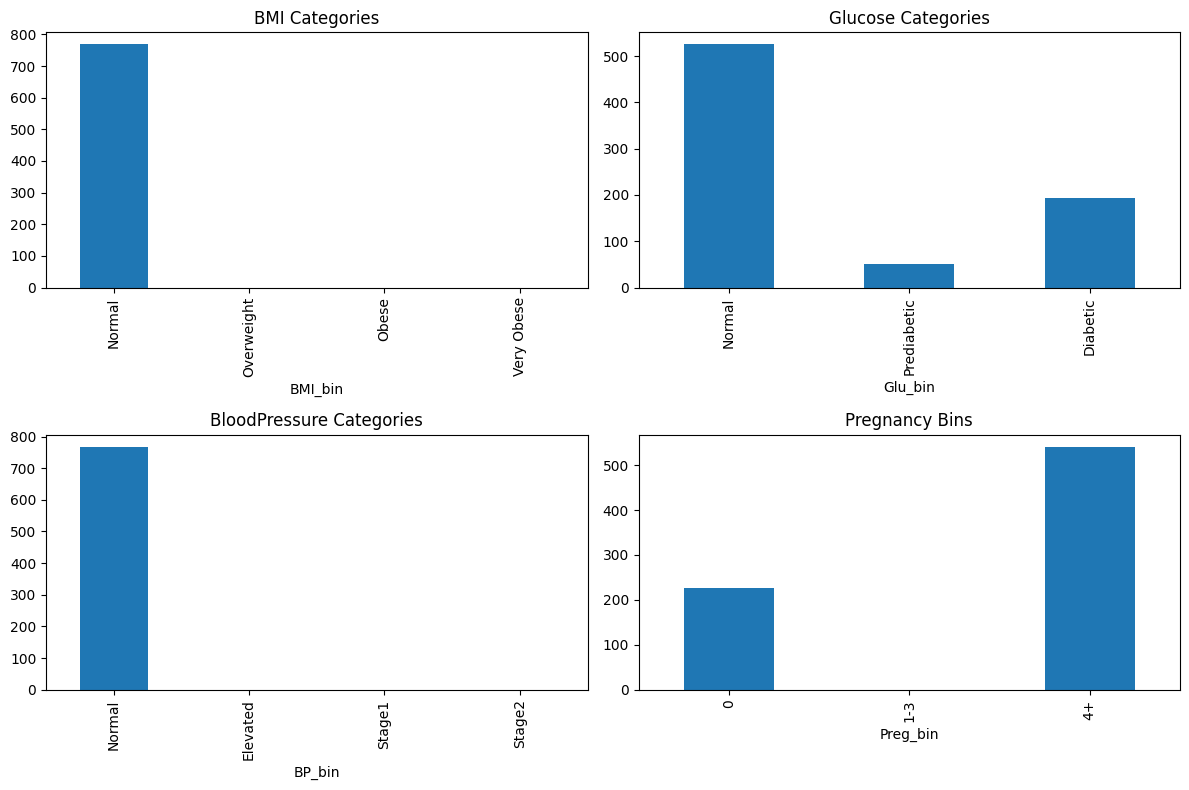

In [11]:
# 2. Visualizations

plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
df['BMI_bin'].value_counts().sort_index().plot(kind='bar', title='BMI Categories')
plt.subplot(2,2,2)
df['Glu_bin'].value_counts().sort_index().plot(kind='bar', title='Glucose Categories')
plt.subplot(2,2,3)
df['BP_bin'].value_counts().sort_index().plot(kind='bar', title='BloodPressure Categories')
plt.subplot(2,2,4)
df['Preg_bin'].value_counts().sort_index().plot(kind='bar', title='Pregnancy Bins')
plt.tight_layout()
plt.show()

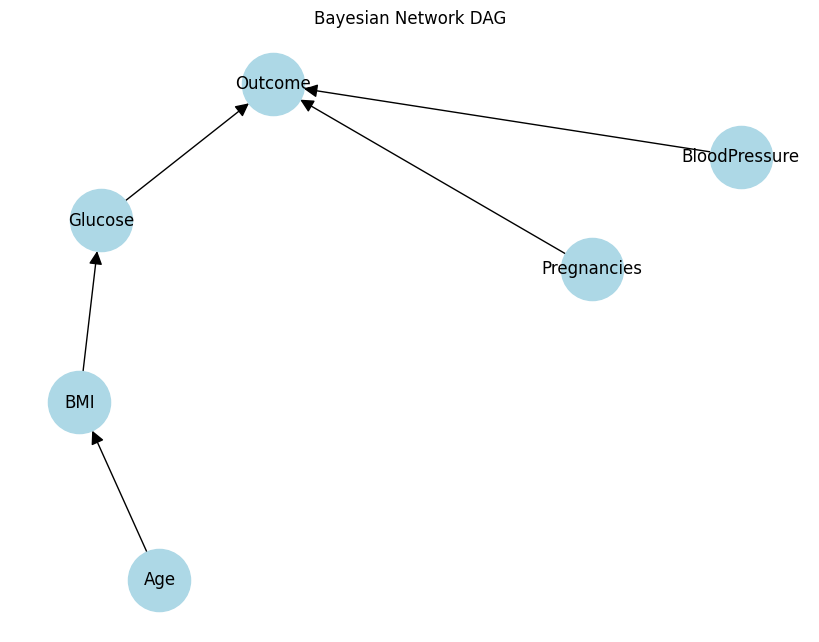

In [12]:
# 3. Build DAG with networkx

G = nx.DiGraph()
nodes = ['Age', 'Pregnancies', 'BMI', 'Glucose', 'BloodPressure', 'Outcome']
G.add_nodes_from(nodes)
edges = [('Age','BMI'), ('BMI','Glucose'),
         ('Pregnancies','Outcome'), ('Glucose','Outcome'),
         ('BloodPressure','Outcome')]
G.add_edges_from(edges)

plt.figure(figsize=(8,6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', arrowsize=20)
plt.title('Bayesian Network DAG')
plt.show()

In [13]:
# 4. Compute CPTs for discrete nodes

def build_cpt(df, child, parents):
    if not parents:
        probs = df[child].value_counts(normalize=True).sort_index()
        return probs.to_frame('P('+child+')')
    grp = df.groupby(parents + [child], observed=False).size().reset_index(name='count')
    grp['total'] = grp.groupby(parents)['count'].transform('sum')
    grp['prob'] = grp['count']/grp['total']
    return grp.pivot_table(index=parents, columns=child, values='prob', observed=False)

cpt_preg = build_cpt(df, 'Preg_bin', [])
cpt_bmi = build_cpt(df, 'BMI_bin', ['Age'])
cpt_glu = build_cpt(df, 'Glu_bin', ['BMI_bin'])
cpt_bp = build_cpt(df, 'BP_bin', [])
cpt_out = build_cpt(df, 'Outcome', ['Glu_bin','Preg_bin','BP_bin'])

# Display CPTs
import IPython.display as disp
print("CPT: P(Preg_bin)")
disp.display(cpt_preg)
print("CPT: P(BMI_bin | Age)  (Age continuous binned into quartiles for display)")
# Bin Age into quartiles for demonstration
df['Age_q'] = pd.qcut(df['Age'], 4, labels=False)
cpt_bmi_ageq = build_cpt(df, 'BMI_bin', ['Age_q'])
disp.display(cpt_bmi_ageq)
print("CPT: P(BP_bin)")
disp.display(cpt_bp)
print("CPT: P(Glu_bin | BMI_bin)")
disp.display(cpt_glu)
print("CPT: P(Outcome | Glu_bin, Preg_bin, BP_bin)")
disp.display(cpt_out)

CPT: P(Preg_bin)


/tmp/ipykernel_12126/1564500049.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp['total'] = grp.groupby(parents)['count'].transform('sum')
/tmp/ipykernel_12126/1564500049.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp['total'] = grp.groupby(parents)['count'].transform('sum')


,P(Preg_bin)
Preg_bin,
0,0.295573
1-3,0.000000
4+,0.704427


CPT: P(BMI_bin | Age)  (Age continuous binned into quartiles for display)


BMI_bin,Normal,Overweight,Obese,Very Obese
Age_q,,,,
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0


CPT: P(BP_bin)


,P(BP_bin)
BP_bin,
Normal,1.0
Elevated,0.0
Stage1,0.0
Stage2,0.0


CPT: P(Glu_bin | BMI_bin)


Glu_bin,Normal,Prediabetic,Diabetic
BMI_bin,,,
Normal,0.683594,0.065104,0.251302


CPT: P(Outcome | Glu_bin, Preg_bin, BP_bin)


Outcome                             0         1
Glu_bin     Preg_bin BP_bin                    
Normal      0        Normal  0.612335  0.387665
            4+       Normal  0.768456  0.231544
Prediabetic 4+       Normal  0.740000  0.260000
Diabetic    4+       Normal  0.492228  0.507772

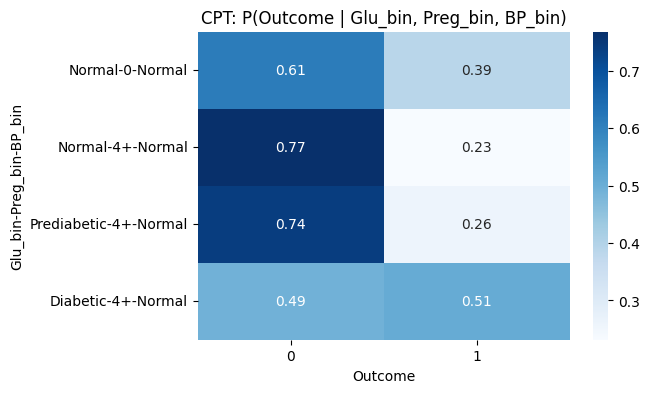

In [14]:
# 5. Heatmap of CPT

import seaborn as sns


plt.figure(figsize=(6,4))
sns.heatmap(cpt_out.fillna(0), annot=True, cmap='Blues')
plt.title('CPT: P(Outcome | Glu_bin, Preg_bin, BP_bin)')
plt.show()

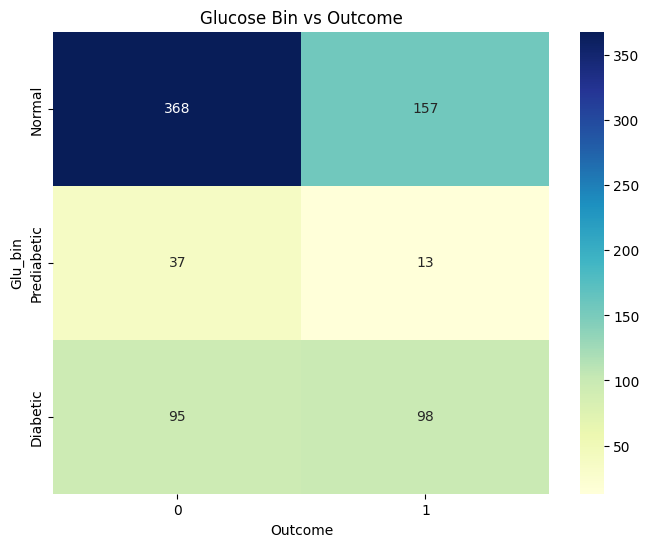

In [15]:
# Create a pivot table
pivot_table = df.pivot_table(index='Glu_bin', columns='Outcome', aggfunc='size', fill_value=0, observed=False)

# Generate the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Glucose Bin vs Outcome')
plt.show()
